# Beijing Air Quality Forecasting Starter Notebook

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
train = pd.read_csv('Data/train.csv', parse_dates=['datetime'], index_col='datetime')
test = pd.read_csv('Data/test .csv', parse_dates=['datetime'], index_col='datetime')



# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# cell 3
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head(10)

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 05:00:00,6,-1.442309,-1.840273,0.053790,-0.155751,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 06:00:00,7,-1.442309,-1.758296,0.053790,-0.093164,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 07:00:00,8,-1.442309,-1.758296,0.053790,-0.057371,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 08:00:00,9,-1.442309,-1.758296,0.053790,0.005216,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


In [5]:
#  the structure of train
print(train.shape)
print(train.info())

# Look at test
print(test.shape)
print(test.info())


# Check missing values
print("Missing values in train:\n", train.isnull().sum())
print("Missing values in test:\n", test.isnull().sum())


(30676, 11)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       30676 non-null  int64  
 1   DEWP     30676 non-null  float64
 2   TEMP     30676 non-null  float64
 3   PRES     30676 non-null  float64
 4   Iws      30676 non-null  float64
 5   Is       30676 non-null  float64
 6   Ir       30676 non-null  float64
 7   cbwd_NW  30676 non-null  float64
 8   cbwd_SE  30676 non-null  float64
 9   cbwd_cv  30676 non-null  float64
 10  pm2.5    28755 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB
None
(13148, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13148 entries, 2013-07-02 04:00:00 to 2014-12-31 23:00:00
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       13148 non-null  int64  
 1   DEWP     13148 non-

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [6]:
# Count of missing values in pm2.5
missing_pm25 = train['pm2.5'].isna().sum()
print("Number of missing values in pm2.5:", missing_pm25)

# Interpolate missing values in the target variable
train['pm2.5'] = train['pm2.5'].interpolate(method='linear')
# Use forward/backward fill as a backup for any remaining NaNs at the ends
train['pm2.5'] = train['pm2.5'].ffill().bfill()

# Verify no missing values remain
print(f"Missing values in pm2.5 after cleaning: {train['pm2.5'].isna().sum()}")

Number of missing values in pm2.5: 1921
Missing values in pm2.5 after cleaning: 0


In [7]:
# Fill missing values in feature columns with their means
feature_columns = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
train[feature_columns] = train[feature_columns].fillna(train[feature_columns].mean())
test[feature_columns] = test[feature_columns].fillna(test[feature_columns].mean()) # Don't forget the test set!

# Verify no missing values remain
print("Missing values in train after cleaning:\n", train.isnull().sum().sum())
print("Missing values in test after cleaning:\n", test.isnull().sum().sum())

Missing values in train after cleaning:
 0
Missing values in test after cleaning:
 0


In [8]:
# Fill missing values in feature columns with their means
feature_columns = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
train[feature_columns] = train[feature_columns].fillna(train[feature_columns].mean())
test[feature_columns] = test[feature_columns].fillna(test[feature_columns].mean()) # Don't forget the test set!

# Verify no missing values remain
print("Missing values in train after cleaning:\n", train.isnull().sum().sum())
print("Missing values in test after cleaning:\n", test.isnull().sum().sum())

Missing values in train after cleaning:
 0
Missing values in test after cleaning:
 0


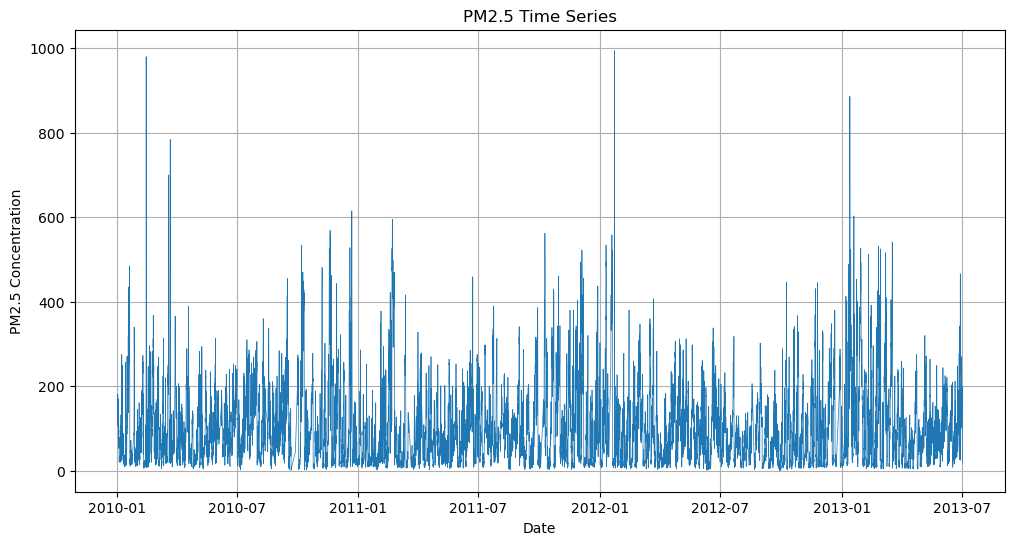

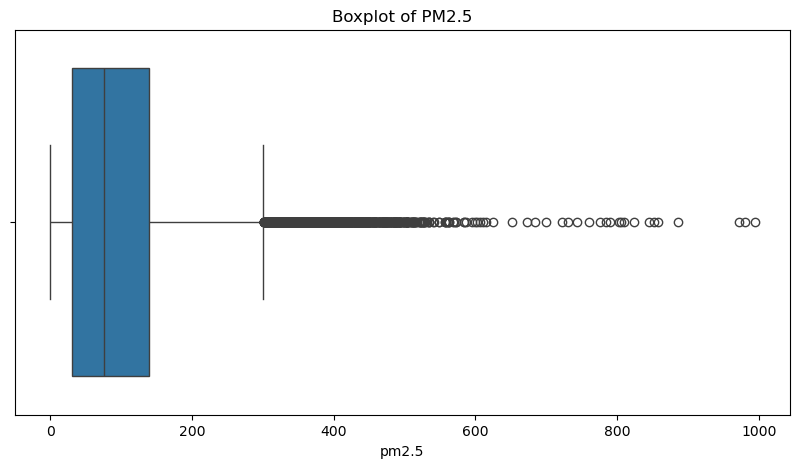

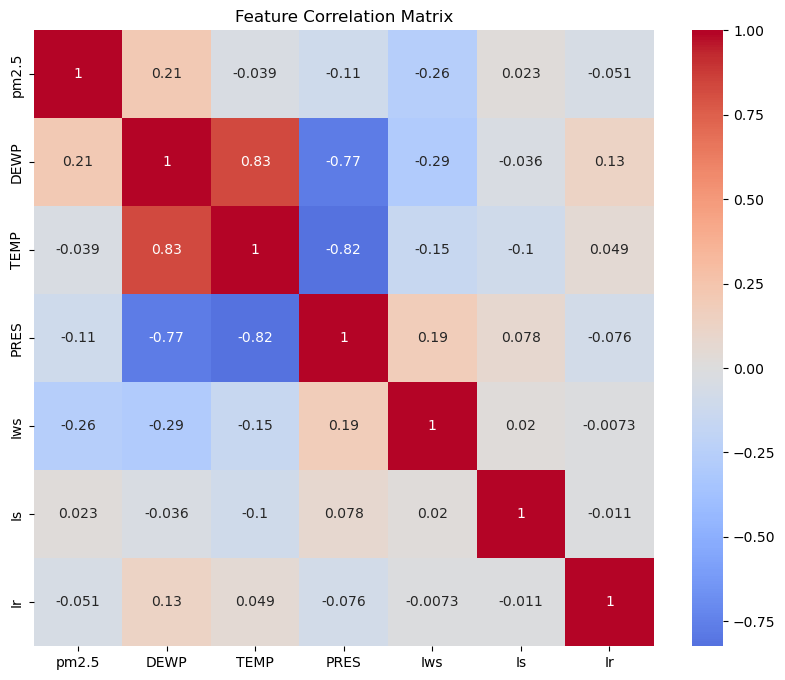

In [9]:
# Plot the PM2.5 time series
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['pm2.5'], linewidth=0.5)
plt.title('PM2.5 Time Series')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.grid(True)
plt.show()

# Boxplot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=train['pm2.5'])
plt.title("Boxplot of PM2.5")
plt.show()

# Check correlation with other features
plt.figure(figsize=(10, 8))
correlation_matrix = train[['pm2.5'] + feature_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [10]:
# Let's start SIMPLE. We will only use the raw features for now.
# This avoids the complex leakage problem. We will add engineered features later.

# Extract simple time-based features from the datetime index
train['hour'] = train.index.hour
train['dayofweek'] = train.index.dayofweek
train['month'] = train.index.month

test['hour'] = test.index.hour
test['dayofweek'] = test.index.dayofweek
test['month'] = test.index.month

# Define the final feature set for our FIRST model
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'hour', 'dayofweek', 'month']
print("Features for initial model:", features)

Features for initial model: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'hour', 'dayofweek', 'month']


In [11]:
# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler() # WE SCALE THE TARGET TOO!

# Fit the feature scaler on training data and transform both train and test
train_scaled_features = feature_scaler.fit_transform(train[features])
test_scaled_features = feature_scaler.transform(test[features])

# Fit the target scaler on the training target only and transform it
# .values.reshape(-1, 1) is necessary for scaler
train_scaled_target = target_scaler.fit_transform(train['pm2.5'].values.reshape(-1, 1))

# Create new DataFrames with scaled values
train_scaled = pd.DataFrame(train_scaled_features, columns=features, index=train.index)
train_scaled['pm2.5'] = train_scaled_target # Add the scaled target

test_scaled = pd.DataFrame(test_scaled_features, columns=features, index=test.index)
# test_scaled doesn't have a target column

print("Train scaled data shape:", train_scaled.shape)
train_scaled.head()

Train scaled data shape: (30676, 10)


,DEWP,TEMP,PRES,Iws,Is,Ir,hour,dayofweek,month,pm2.5
datetime,,,,,,,,,,
2010-01-01 00:00:00,-1.560701,-1.831739,0.425893,-0.463936,-0.079415,-0.13999,-1.661016,0.498616,-1.488515,0.315438
2010-01-01 01:00:00,-1.560701,-1.912491,0.329375,-0.402474,-0.079415,-0.13999,-1.516563,0.498616,-1.488515,0.315438
2010-01-01 02:00:00,-1.560701,-1.831739,0.232857,-0.367326,-0.079415,-0.13999,-1.372111,0.498616,-1.488515,0.315438
2010-01-01 03:00:00,-1.560701,-2.073995,0.232857,-0.305864,-0.079415,-0.13999,-1.227658,0.498616,-1.488515,0.315438
2010-01-01 04:00:00,-1.491003,-1.912491,0.136339,-0.244403,-0.079415,-0.13999,-1.083206,0.498616,-1.488515,0.315438


In [12]:
# Define sequence length (using 24 hours of history to predict the next hour)
TIME_STEPS = 24

def create_sequences_optimized(data, features, target, time_steps=TIME_STEPS):
    """
    Creates input sequences (X) and target values (y) from the data.
    This function is safe from data leakage and MUCH more memory efficient.
    """
    data_size = len(data)
    num_features = len(features)
    
    # Pre-allocate arrays for speed and memory efficiency
    # The number of samples is: total_data_points - time_steps
    num_samples = data_size - time_steps
    
    # X shape will be (num_samples, time_steps, num_features)
    X = np.zeros((num_samples, time_steps, num_features))
    # y shape will be (num_samples,)
    y = np.zeros((num_samples,))
    
    # Loop through the data to create each sample
    # This loop is now just filling pre-allocated arrays, which is fast.
    for i in range(time_steps, data_size):
        # Calculate the index for the new arrays
        sample_index = i - time_steps 
        
        # Fill the X array for this sample
        # We get a chunk of data and assign it directly
        X[sample_index] = data[features].iloc[i-time_steps:i].values
        # Fill the y value for this sample
        y[sample_index] = data[target].iloc[i]
        
    return X, y

print("Creating sequences (this will be much faster and use less memory)...")
# Create sequences for the training data
X, y = create_sequences_optimized(train_scaled, features, 'pm2.5', TIME_STEPS)

print(f"X shape: {X.shape}")  # (samples, timesteps, features)
print(f"y shape: {y.shape}")  # (samples,)

Creating sequences (this will be much faster and use less memory)...
X shape: (30652, 24, 9)
y shape: (30652,)


In [13]:
# === EFFICIENT TIME-BASED SPLIT ===
import pandas as pd
import numpy as np

# Convert index to datetime
train_scaled.index = pd.to_datetime(train_scaled.index)

# Use last 20% of time for validation
split_index = int(0.8 * len(train_scaled))
split_date = train_scaled.index[split_index]

print(f"Splitting at date: {split_date}")
print(f"Training period: {train_scaled.index[0]} to {split_date}")
print(f"Validation period: {split_date} to {train_scaled.index[-1]}")

# Get all possible starting indices for sequences
start_indices = np.arange(TIME_STEPS, len(train_scaled))

# Create boolean mask for training vs validation
is_training = train_scaled.index[TIME_STEPS:] < split_date
is_validation = ~is_training

print(f"Training sequences: {is_training.sum()}")
print(f"Validation sequences: {is_validation.sum()}")

# Pre-allocate arrays for efficiency
X_train = np.zeros((is_training.sum(), TIME_STEPS, len(features)))
X_val = np.zeros((is_validation.sum(), TIME_STEPS, len(features)))
y_train = np.zeros(is_training.sum())
y_val = np.zeros(is_validation.sum())

# Fill training arrays
train_idx = 0
for i in start_indices[is_training]:
    X_train[train_idx] = train_scaled[features].iloc[i-TIME_STEPS:i].values
    y_train[train_idx] = train_scaled['pm2.5'].iloc[i]
    train_idx += 1

# Fill validation arrays  
val_idx = 0
for i in start_indices[is_validation]:
    X_val[val_idx] = train_scaled[features].iloc[i-TIME_STEPS:i].values
    y_val[val_idx] = train_scaled['pm2.5'].iloc[i]
    val_idx += 1

print(f"Training Data - X: {X_train.shape}, y: {y_train.shape}")
print(f"Validation Data - X: {X_val.shape}, y: {y_val.shape}")

# Check statistics
if 'target_scaler' in globals():
    y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    print(f"\nValidation target stats:")
    print(f"  Mean: {y_val_original.mean():.2f}")
    print(f"  Std: {y_val_original.std():.2f}")
    print(f"  Range: [{y_val_original.min():.2f}, {y_val_original.max():.2f}]")

Splitting at date: 2012-10-19 12:00:00
Training period: 2010-01-01 00:00:00 to 2012-10-19 12:00:00
Validation period: 2012-10-19 12:00:00 to 2013-07-02 03:00:00
Training sequences: 24516
Validation sequences: 6136
Training Data - X: (24516, 24, 9), y: (24516,)
Validation Data - X: (6136, 24, 9), y: (6136,)

Validation target stats:
  Mean: 112.50
  Std: 106.02
  Range: [4.00, 886.00]


In [15]:
# Check if your validation set has very different statistics
print("Training target stats:")
print(f"  Mean: {train['pm2.5'].mean():.2f}")
print(f"  Std: {train['pm2.5'].std():.2f}")
print(f"  Range: [{train['pm2.5'].min():.2f}, {train['pm2.5'].max():.2f}]")

print("\nValidation actual values stats:")
val_actual_original = target_scaler.inverse_transform(y_val.reshape(-1, 1))
print(f"  Mean: {val_actual_original.mean():.2f}")
print(f"  Std: {val_actual_original.std():.2f}")
print(f"  Range: [{val_actual_original.min():.2f}, {val_actual_original.max():.2f}]")

Training target stats:
  Mean: 100.15
  Std: 91.47
  Range: [0.00, 994.00]

Validation actual values stats:
  Mean: 112.50
  Std: 106.02
  Range: [4.00, 886.00]


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [14]:
from tensorflow.keras.regularizers import l2

# Clear previous model
tf.keras.backend.clear_session()

# Build a robust, well-regularized model
model = Sequential()

# First LSTM layer with regularization
model.add(LSTM(units=128, return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_regularizer=l2(0.01),  # Strong L2 regularization
               recurrent_regularizer=l2(0.01),
               bias_regularizer=l2(0.01)))
model.add(Dropout(0.6))  # High dropout

# Second LSTM layer with regularization  
model.add(LSTM(units=64,
               kernel_regularizer=l2(0.01),
               recurrent_regularizer=l2(0.01),
               bias_regularizer=l2(0.01)))
model.add(Dropout(0.6))  # High dropout

# Output layer
model.add(Dense(1))

# Use a lower learning rate with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

2025-09-21 22:38:33.086716: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/chris/miniconda3/envs/deepclass/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# More patient callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=20,  # Very patient
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,  # More patient before reducing LR
    min_lr=1e-7,
    verbose=1
)

# Train with larger batch size for better generalization
history = model.fit(
    X_train, y_train,
    epochs=100,  # Set high, let early stopping handle it
    batch_size=128,  # Larger batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - loss: 5.1025 - mae: 0.6493 - val_loss: 3.0605 - val_mae: 0.6329 - learning_rate: 5.0000e-04
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - loss: 2.5575 - mae: 0.5494 - val_loss: 2.3351 - val_mae: 0.6153 - learning_rate: 5.0000e-04
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - loss: 2.0216 - mae: 0.5491 - val_loss: 1.9856 - val_mae: 0.6078 - learning_rate: 5.0000e-04
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - loss: 1.6802 - mae: 0.5336 - val_loss: 1.7043 - val_mae: 0.5986 - learning_rate: 5.0000e-04
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - loss: 1.4308 - mae: 0.5249 - val_loss: 1.5012 - val_mae: 0.5967 - learning_rate: 5.0000e-04
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 58s 119ms/step - loss: 1.2360 - mae: 0.5227 - val_loss: 1.3671 - val_mae: 0.5924 - learning_rate: 5.0000e-04
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - loss: 1.1077 - mae: 0.5256 - val_loss: 1.2

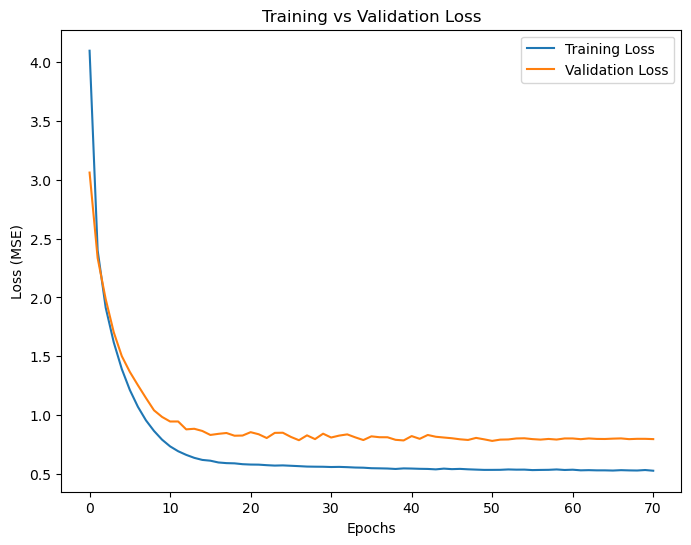

In [17]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


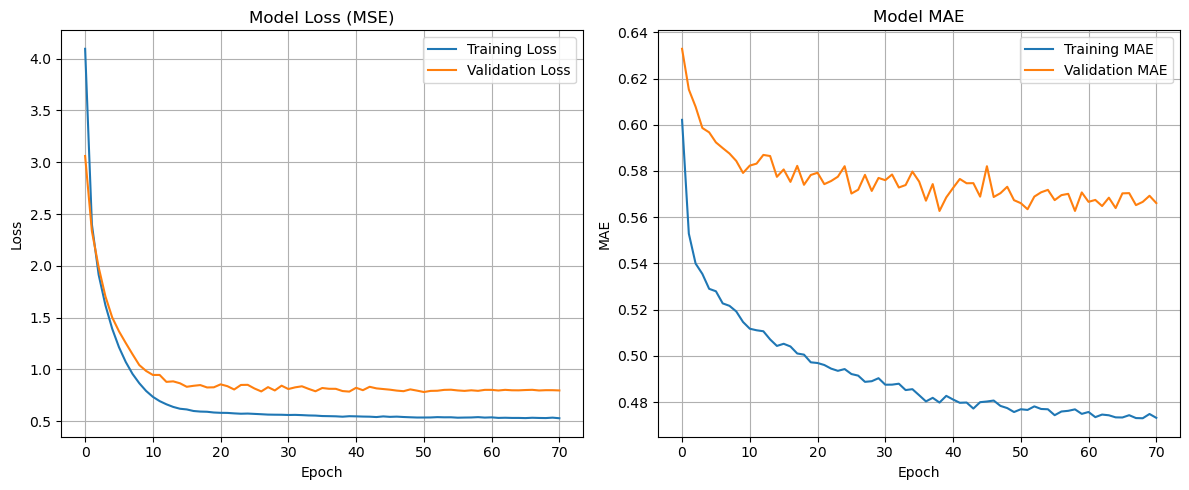

192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

Validation RMSE: 75.78


In [ ]:
# Plot training history
from sklearn.metrics import mean_squared_error
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Make predictions on the validation set
y_pred_scaled = model.predict(X_val)

# Inverse transform the predictions and actual values to original scale
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)
y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1))

# Calculate RMSE on the original scale
val_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
print(f"\nValidation RMSE: {val_rmse:.2f}")



In [ ]:
# SIMPLE BASELINE PREDICTION


# Get the last PM2.5 value from the training set
last_pm25_value = train['pm2.5'].iloc[-1]

# Create submission using this constant value for all predictions
sample_sub = pd.read_csv('Data/sample_submission .csv')
submission_simple = pd.DataFrame({
    'row ID': sample_sub['row ID'],
    'pm2.5': [last_pm25_value] * len(sample_sub)  # Repeat the last value
})

# Save this simple submission
submission_simple.to_csv('submissions/simple_baseline.csv', index=False)
print(f"Simple baseline submission created using last training value: {last_pm25_value}")

Simple baseline submission created using last training value: 18.0


In [22]:
# DIAGNOSTIC: Check sample submission structure
sample_sub = pd.read_csv('Data/sample_submission .csv')
print("Sample submission info:")
print(sample_sub.head())
print(f"\nShape: {sample_sub.shape}")
print(f"Unique row IDs: {sample_sub['row ID'].nunique()}")
print(f"Row ID range: {sample_sub['row ID'].min()} to {sample_sub['row ID'].max()}")

# Check if there's a specific format expected
print(f"\nFirst few row IDs:")
print(sample_sub['row ID'].head().values)

# Check if we need to use specific indices
print(f"\nTest set index range:")
print(f"Start: {test.index.min()}, End: {test.index.max()}")

Sample submission info:
               row ID  pm2.5
0  2013-07-02 4:00:00     14
1  2013-07-02 5:00:00     14
2  2013-07-02 6:00:00     14
3  2013-07-02 7:00:00     14
4  2013-07-02 8:00:00     14

Shape: (13148, 2)
Unique row IDs: 13148
Row ID range: 2013-07-02 10:00:00 to 2014-12-31 9:00:00

First few row IDs:
['2013-07-02 4:00:00' '2013-07-02 5:00:00' '2013-07-02 6:00:00'
 '2013-07-02 7:00:00' '2013-07-02 8:00:00']

Test set index range:
Start: 2013-07-02 04:00:00, End: 2014-12-31 23:00:00


In [26]:
# ===== COMPLETE PREDICTION PIPELINE =====
import pandas as pd
import numpy as np

# 1. Load sample submission to get the correct row IDs
sample_sub = pd.read_csv('Data/sample_submission .csv')
print("Sample submission loaded. First row ID:", sample_sub['row ID'].iloc[0])

# 2. Get the last TIME_STEPS from the scaled TRAINING data
last_train_sequence = train_scaled[features].iloc[-TIME_STEPS:].values
print(f"Last train sequence shape: {last_train_sequence.shape}")  # FIXED: consistent variable name

# 3. Prepare the test set sequences for prediction
X_test_list = []
current_sequence = last_train_sequence

for i in range(len(test)):
    X_test_list.append(current_sequence)    
    current_test_features = test_scaled[features].iloc[i].values
    current_sequence = np.vstack([current_sequence[1:], [current_test_features]])

X_test_final = np.array(X_test_list)
print(f"X_test_final shape: {X_test_final.shape}")

# 4. Make predictions
print("Making predictions...")
predictions_scaled = model.predict(X_test_final, verbose=1)
predictions_scaled = np.nan_to_num(predictions_scaled)

# 5. Inverse transform and clip negative values
predictions = target_scaler.inverse_transform(predictions_scaled)
predictions = np.clip(predictions, 0, None)  # PM2.5 can't be negative
print(f"Predictions range: [{predictions.min():.2f}, {predictions.max():.2f}]")

# 6. Create submission with exact original row ID format
submission = pd.DataFrame({
    'row ID': sample_sub['row ID'],  # Keep original string format
    'pm2.5': predictions.flatten()   # Use our predictions directly
})

# 7. Final validation checks
print(f"\nFinal submission shape: {submission.shape}")
print(f"Sample submission shape: {sample_sub.shape}")
print(f"Row IDs match: {submission['row ID'].equals(sample_sub['row ID'])}")
print(f"Missing values: {submission['pm2.5'].isnull().sum()}")
print(f"Final prediction range: [{submission['pm2.5'].min():.2f}, {submission['pm2.5'].max():.2f}]")

# 8. Save
submission.to_csv('submissions/final_submission.csv', index=False)
print("Final submission saved: submissions/final_submission.csv")

Sample submission loaded. First row ID: 2013-07-02 4:00:00
Last train sequence shape: (24, 9)
X_test_final shape: (13148, 24, 9)
Making predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step
Predictions range: [0.00, 355.93]

Final submission shape: (13148, 2)
Sample submission shape: (13148, 2)
Row IDs match: True
Missing values: 0
Final prediction range: [0.00, 355.93]
Final submission saved: submissions/final_submission.csv
